# Satellite Data Milan

- Remove the #  to run once you have installed and imported earth engine `ee`

- Change file directory to load location of Italy

In [2]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()
#import geemap

Enter verification code: 4/1ARtbsJrNFqOeEbEh2_g1l6mhqVI_8sBVeSaPy-I0jYjjCYOd_XPVB_5cXW8

Successfully saved authorization token.


 Uisnf MODIS Data source extract the followings 


- Land cover `LC`

-  Land Surface temperature`LST`

Using USGS

- Ground elevation `ELV`


In [3]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

In [4]:
print(lc)

ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "ImageCollection.load",
    "arguments": {
      "id": {
        "constantValue": "MODIS/006/MCD12Q1"
      }
    }
  }
})


- **Features**: geometric objects with a list of properties. `ee.Feature`.

- **Image**: similar to features, but may include several **bands**, `ee.Image`

- **Collections** which are groups of features or images

- since all images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST to a single image representing data for the year 2000 in a 30 m resolution for the ELV,GEE takes care of resolution (called `scale` in GEE) and projection by resampling and reprojecting all data we are going to work with to a common projection.

- Then, we have to filter the collection on the period of time we want. We can do that using the filterDate() method.

- Then, we have to filter the collection on the period of time we want using the `filterDate()` methodand ` select()` method.

In [5]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

- **LST_DAY_1km**: Daytime Land Surface Temperature

- **QC_Day** quality indicator

**Define Area of Interst (AOI)**

- define Itally as a country using longtiudeand latitude

- Select two region in Itally for comapresion using longitude and latitude

geting map of **Itally** also possble from [Natural Earth](https://www.naturalearthdata.com) by deploying `geopands`

- Itally is located in the worlld map   with  

 > - latitude  =  41.8719° N, 
 > - longitude = 12.5674° E

In [6]:
# Define Itally as AOI.
it_lon = 12.5674
it_lat = 41.871
#define a point arround Ittaly
it_poi = ee.Geometry.Point(it_lon, it_lat)

- Two important issues during LST determination

 > - correction factor 0.02 for kelvie `k` and 
 > -  Conversion  to centigrade 
 
- Scale is noting insteds to show how one pixel stands for

In [7]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_it = elv.sample(it_poi, scale).first().get('elevation').getInfo()
print('Ground elevation of Itally:', elv_it, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_it = lst.mean().sample(it_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST of Italy is:', round(lst_it*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_it = lc.first().sample(it_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value of Italy is:', lc_it)

Ground elevation of Itally: 49 m
Average daytime LST of Italy is: 28.33 °C
Land cover value of Italy is: 13


**Getting timeseries data**

In [8]:
# Get the data for the pixel intersecting the point in urban area.
lst_it = lst.getRegion(it_poi, scale).getInfo()


# Preview the result.
lst_it[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01',
  12.562939248411508,
  41.874966969231494,
  1483228800000,
  14116,
  81],
 ['2017_01_02',
  12.562939248411508,
  41.874966969231494,
  1483315200000,
  None,
  2],
 ['2017_01_03',
  12.562939248411508,
  41.874966969231494,
  1483401600000,
  None,
  2],
 ['2017_01_04',
  12.562939248411508,
  41.874966969231494,
  1483488000000,
  14167,
  81]]

- lets have dataframe of list

In [9]:
import pandas as pd
df =pd.DataFrame(lst_it)
# redefine headers
headers = df.iloc[0]
df  = pd.DataFrame(df.values[1:], columns=headers)
df.head()

,id,longitude,latitude,time,LST_Day_1km,QC_Day
0,2017_01_01,12.562939,41.874967,1483228800000,14116,81
1,2017_01_02,12.562939,41.874967,1483315200000,None,2
2,2017_01_03,12.562939,41.874967,1483401600000,None,2
3,2017_01_04,12.562939,41.874967,1483488000000,14167,81
4,2017_01_05,12.562939,41.874967,1483574400000,14127,81


- see several `None` values appear in the **LST_Day_1km column**. 

- The associated quality indicator **QC_Day** indicates a value of 2 meaning that the `LST` is not calculated because of cloud effects.

- while We redefine a function to transform this array into a pandas Dataframe  below  algorithm  for dataframe  is much more convenient to manipulate.

In [10]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [11]:
lst_df_it = ee_array_to_df(lst_it,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_it['LST_Day_1km'] = lst_df_it['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_it.head()

,time,datetime,LST_Day_1km
0,1483228800000,2017-01-01,9.17
3,1483488000000,2017-01-04,10.19
4,1483574400000,2017-01-05,9.39
5,1483660800000,2017-01-06,4.49
6,1483747200000,2017-01-07,3.53


- Expect that LST has a seasonality influence in our ROI,the sinusoidal trend described by Stallman (1965):
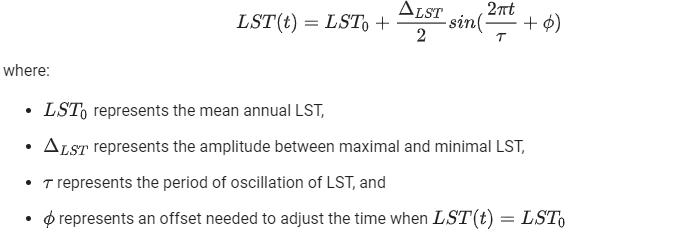

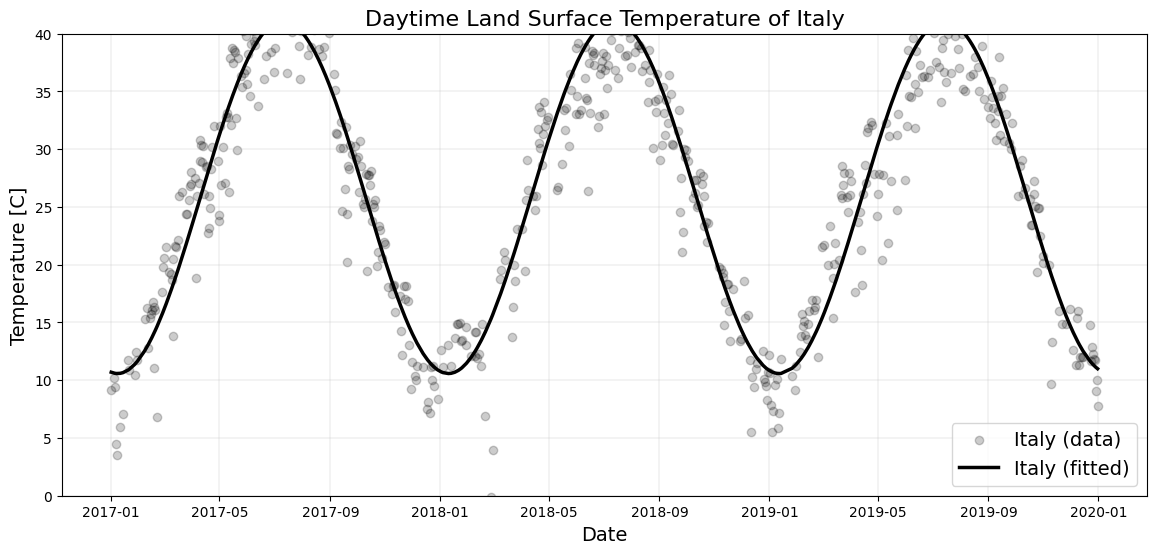

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_it = np.asanyarray(lst_df_it['time'].apply(float))  

## Secondly, extract y values (LST) from the dfs.
y_data_it = np.asanyarray(lst_df_it['LST_Day_1km'].apply(float)) 


## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_it, y_data_it, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_it['datetime'], lst_df_it['LST_Day_1km'],
           c='black', alpha=0.2, label='Italy (data)')
# Add fitting curves.
ax.plot(lst_df_it['datetime'],
        fit_func(x_data_it, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Italy (fitted)', color='black', lw=2.5)


# Add some parameters.
ax.set_title('Daytime Land Surface Temperature of Italy', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

- Lets convert the **LST** `ee.ImageCollection` into an `ee.Image`, and value of `pixels` into `Celsius`

- Then use the `getThumbUrl()` method to get a `URL` and we can use the IPython library to display the mean daytime `LST` map for Itally as ROI. 

- **Blue** represents the **coldest areas** (< 10°C) and

- **Red** represents the **warmest areas** (> 30°C) 

In [13]:
# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [14]:
from IPython.display import Image
# Define a region of interest with a buffer zone of 1000 km around .
roi = it_poi.buffer(1e6)

# Create a URL to the styled image for a region around France.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c93040fbfd0955caad7f736cb945191-eba156cafd4472bfcb5cba132aec9ed1:getPixels

Please wait while the thumbnail loads, it may take a moment...


- clickink the link abve gives
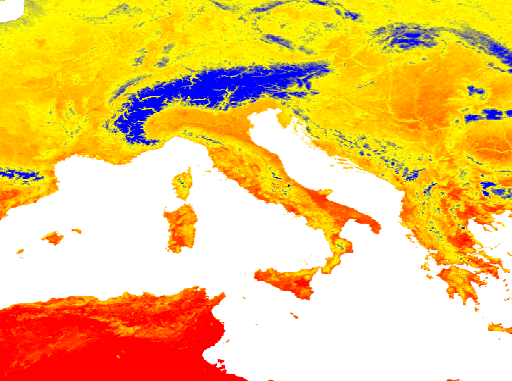

 - Do the same for ground elevation:

In [15]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in France.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 2000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

Of course you may want to have a closer look around a specific part of the map. 

So let's define another region (a buffer zone around Italy), adjust the min/max scale and display:

In [16]:
# Create a buffer zone of 10 km around Lyon.
italy = it_poi.buffer(10000)  # meters

url = elv_img.getThumbUrl({
    'min': 150, 'max': 350, 'region': italy, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

In [17]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
italy = countries.filter(ee.Filter.eq('ADM0_NAME', 'Italy'))

# Clip the image by France.
elv_fr = elv_img.clip(italy)

# Create the URL associated with the styled image data.
url = elv_fr.getThumbUrl({
    'min': 0, 'max': 2500, 'region': roi, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Itally.
Image(url=url)

**Export a GeoTIFF file**

- We may need to export a resulting `ee.Image to a GeoTIFF`

- let us save it on google drive with

 > - size of pixels = 30m
 > - projection:  `EPSG:4326`
 >-file format: `GeoTIFF`
 >-

In [18]:
task = ee.batch.Export.image.toDrive(image=elv_img,
                                     description='elevation_italy',
                                     scale=30,
                                     region=italy,
                                     fileNamePrefix='my_export_italy',
                                     crs='EPSG:4326',
                                     fileFormat='GeoTIFF')
task.start()

In [19]:
task.status()

{'state': 'READY',
 'description': 'elevation_italy',
 'creation_timestamp_ms': 1665374470513,
 'update_timestamp_ms': 1665374470513,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'BZTY7RGFIYQZHYHSHGIL3QMK',
 'name': 'projects/earthengine-legacy/operations/BZTY7RGFIYQZHYHSHGIL3QMK'}

**Interactive mapping using folium**

- Folium is a python library based on leaflet.js (open-source JavaScript library for mobile-friendly interactive maps

In [20]:
import folium

# Define the center of our map.
it_lon = 12.5674
it_lat = 41.871

my_map = folium.Map(location=[it_lat, it_lon], zoom_start=5)
my_map

On top of this map, we now want to add the GEE layers we studied before: 

- land cover (LC), 

- land surface temperature (LST) and 

-  ground elevation model (ELV).

For each GEE dataset, the process consists of adding a new tile layer to our map with specified visualization parameters. Let's define a new method for handing Earth Engine tiles and using it to display an elevation model to a Leaflet map.

In [21]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

**common LC classes**

- water bodies are **blue**,

- urban areas are **grey**, 

- forests are **green**

In [22]:
# Select a specific band and dates for land cover.
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
my_map = folium.Map(location=[it_lat, it_lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

- Of course we can add other datasets similarly, by defining some visualization parameters and by adding the appropriate tiles:

In [23]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 0, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map

**Vegetation Index  VI** 

- Detail **VI** plently available in the literature of the state of the art.

- As common and best method of **VI** and as measure of drought indicator, Normailized diference vegitation index,`NDVI` is best calculated using raster data.

- **NDVI**allow usto generate an image displaying` greenness (relative biomass)`. 

- It  takes advantage of the contrast of the characteristics of two bands from a **multispectral raster dataset**—

  > - the **chlorophyll pigment absorptions** in the `red band` and 
  > - the **high reflectivity of plant materials** in the `near-infrared (NIR) band`.
  
 While more is obtained [here](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/ndvi-function.htm) about **NDVI** a general documentation is given below:
 
$ NDVI = \frac{IR - R}{IR + R}$

 > - `IR`= pixel values from the infrared band
 > - `R` = pixel values from the red band

- **NDVI imlications**

where NDVI is to representing **greenness**

- $NDVI\in[-1,1]$: 

- $NDVI  < 0$:  mainly generated from clouds, water, and snow,

- $NDVI\approx 0$ : mainly generated from rock and bare soil.

- $0< NDVI \le 0.1$ :**Low NDVI** and correspond to barren areas of rock, sand, or snow.

- $0.2\le NDVI \le 0.3$: **Moderate NDVI** and represent **shrub and grassland**, while

- $0.6\le NDVI\le 0.8$: **high NDVI** and indicate temperate and tropical rainforests.

-  Hence, since our concern is food security, which is highly dependent to vegtation index, NDVI is a straightforward to our satellite imagery based food security analysis 

- One important extention of **NDIV** to disscused also is `Enhanced vegetation index` **EVI** to correct some atmospheric conditions and canopy background noise.

-  EVI is more sensitive in areas with dense vegetation

- It incorporates

 > - `L` value to **adjust for canopy background**
 > - `C` values as **coefficients for atmospheric resistance**, and 
 > - values from the `blue band (B)`
 
 $EVI = G*\frac{NIR - R}{NIR + C1 * R – C2 * B + L}$
 
 - mostly, `G=2.5`,$C_1 =6$ and $C_2 =7.5$
 
 For more [see here](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index#:~:text=Landsat%20Enhanced%20Vegetation%20Index%20(EVI,in%20areas%20with%20dense%20vegetation.)

**Define starting and ending year of study**

In [24]:
# Longer the duration, Longer it will take for Processing and downloading of Images
StartDate = '2020-05-01'
EndDate = '2021-04-30'

**Define area of interest AOI**

- Take Itally as AOI

-  Define Itally as polygon from map using `geemap`

- Extract features with class `geometry`

- redefine the polygon  for not reloading the map

In [25]:
#define Italy as polygon
import numpy as np
import pandas as pd
import ee
import geemap
ee.Initialize()
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


In [28]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [29]:
# extract features fo AOI
feature =Map.draw_last_feature
AOI = feature.geometry()
AOI.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[12.525782, 38.003197],
   [13.580604, 38.176132],
   [15.690248, 38.279696],
   [16.349512, 39.239167],
   [16.129757, 39.916583],
   [14.239868, 40.853812],
   [12.569733, 41.548159],
   [11.690714, 42.397601],
   [10.855647, 42.979033],
   [10.372187, 43.714046],
   [9.668972, 44.314514],
   [8.570199, 44.502872],
   [8.042788, 43.999236],
   [7.295623, 44.408769],
   [6.724261, 44.971113],
   [6.944015, 45.835019],
   [7.735132, 46.048931],
   [8.877856, 46.140355],
   [10.152432, 46.444008],
   [11.251205, 46.896332],
   [12.349978, 46.715856],
   [13.536653, 46.745978],
   [13.053193, 46.383412],
   [12.92134, 45.773749],
   [12.086273, 45.435563],
   [12.130224, 44.440153],
   [13.185046, 43.714046],
   [14.020113, 42.688997],
   [15.602346, 41.548159],
   [18.063598, 40.620728],
   [16.701119, 40.152112],
   [17.22853, 39.034653],
   [16.305561, 38.176132],
   [15.206788, 37.829853],
   [14.987033, 36.921901],
   [13.185

- Following is coordinate for Italy as Polygon and would help to demonstraite without reloading  geemap

- one can substitute ROI to the `col` simply in the function of `Min_Max_Mean` below, and continue runing.

- 

In [38]:
pol_italy = ee.Geometry.Polygon([[[12.525782, 38.003197],
                                 [13.580604, 38.176132],
                                 [15.690248, 38.279696],
                                 [16.349512, 39.239167],
                                 [16.129757, 39.916583],
                                 [14.239868, 40.853812],
                                 [12.569733, 41.548159],
                                 [11.690714, 42.397601],
                                 [10.855647, 42.979033],
                                 [10.372187, 43.714046],
                                 [9.668972, 44.314514],
                                 [8.570199, 44.502872],
                                 [8.042788, 43.999236],
                                 [7.295623, 44.408769],
                                 [6.724261, 44.971113],
                                 [6.944015, 45.835019],
                                 [7.735132, 46.048931],
                                 [8.877856, 46.140355],
                                 [10.152432, 46.444008],
                                 [11.251205, 46.896332],
                                 [12.349978, 46.715856],
                                 [13.536653, 46.745978],
                                 [13.053193, 46.383412],
                                 [12.92134, 45.773749],
                                 [12.086273, 45.435563],
                                 [12.130224, 44.440153],
                                 [13.185046, 43.714046],
                                 [14.020113, 42.688997],
                                 [15.602346, 41.548159],
                                 [18.063598, 40.620728],
                                 [16.701119, 40.152112],
                                 [17.22853, 39.034653],
                                 [16.305561, 38.176132],
                                 [15.206788, 37.829853],
                                 [14.987033, 36.921901],
                                 [13.185046, 37.516806],
                                 [12.525782, 38.003197]]])

- Lets proced for minimum and maximu NDVI for crop  prediction in itally and all the algorithm that orginated from GEE are adpated from this [gitsub](https://github.com/krishnakafle/Blog_kaflekrishna/tree/main/GEE/min-max-mean-graph-polygon-ndvi)

In [39]:
ens = [
    ee.Feature(pol_italy, {'name': 'italy-crop-poly', 'id':1})
]

col =  ee.FeatureCollection(ens)
print(col.getInfo())

{'type': 'FeatureCollection', 'columns': {'id': 'Integer', 'name': 'String', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[12.525782, 38.003197], [13.185046, 37.516806], [14.987033, 36.921901], [15.206788, 37.829853], [16.305561, 38.176132], [17.22853, 39.034653], [16.701119, 40.152112], [18.063598, 40.620728], [15.602346, 41.548159], [14.020113, 42.688997], [13.185046, 43.714046], [12.130224, 44.440153], [12.086273, 45.435563], [12.92134, 45.773749], [13.053193, 46.383412], [13.536653, 46.745978], [12.349978, 46.715856], [11.251205, 46.896332], [10.152432, 46.444008], [8.877856, 46.140355], [7.735132, 46.048931], [6.944015, 45.835019], [6.724261, 44.971113], [7.295623, 44.408769], [8.042788, 43.999236], [8.570199, 44.502872], [9.668972, 44.314514], [10.372187, 43.714046], [10.855647, 42.979033], [11.690714, 42.397601], [12.569733, 41.548159], [14.239868, 40.853812], [16.129757, 39.916583], [16.349512, 39.239167], [15.6902

- Now it is time to invok time for each image

In [40]:
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

In [41]:
# add satellite time series: MODIS EVI 250m 16 day -------------
# terra sensor
collectionModEvi_terra = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(StartDate,EndDate) \
    .filterBounds(pol_italy)\
    .select('EVI')

# Aqua sensor
collectionModEvi_aqua = ee.ImageCollection('MODIS/061/MYD13Q1').filterDate(StartDate,EndDate) \
    .filterBounds(pol_italy)\
    .select('EVI');

collectionModEvi = collectionModEvi_terra.merge(collectionModEvi_aqua)
# THis will provide us 250 m of EVI datasets from MODIS on 8 day interval

- Extract Minimum,Maximum and Mean value of EVI

-  To run with `RO` the Map function should be realed by the kernl otherwise error would reported

- Runing with `Col` however, static as it alredfy from predefined polygon coordinates

In [56]:
def extractMinMaxMean(image):
    return image.reduceRegions(**{
    'collection':ROI,
    'reducer':ee.Reducer.minMax().combine(ee.Reducer.mean(), '', True), 
  })

In [57]:
sample_result = ModEVI.first().getInfo()
sample_result

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': [[[12.525782, 38.003197],
    [13.185046, 37.516806],
    [14.987033, 36.921901],
    [15.206788, 37.829853],
    [16.305561, 38.176132],
    [17.22853, 39.034653],
    [16.701119, 40.152112],
    [18.063598, 40.620728],
    [15.602346, 41.548159],
    [14.020113, 42.688997],
    [13.185046, 43.714046],
    [12.130224, 44.440153],
    [12.086273, 45.435563],
    [12.92134, 45.773749],
    [13.053193, 46.383412],
    [13.536653, 46.745978],
    [12.349978, 46.715856],
    [11.251205, 46.896332],
    [10.152432, 46.444008],
    [8.877856, 46.140355],
    [7.735132, 46.048931],
    [6.944015, 45.835019],
    [6.724261, 44.971113],
    [7.295623, 44.408769],
    [8.042788, 43.999236],
    [8.570199, 44.502872],
    [9.668972, 44.314514],
    [10.372187, 43.714046],
    [10.855647, 42.979033],
    [11.690714, 42.397601],
    [12.569733, 41.548159],
    [14.239868, 40.853812],
    [16.129757, 39.916583],
    [16.349512, 39

In [58]:
# extract the properties column from feature collection
# column order may not be as our sample data order
column_df = ['EVI_mean', 'EVI_min', 'EVI_max', 'date_min', 'id', 'name']

In [59]:
nested_list = ModEVI.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
data = nested_list.getInfo()
data

[[4537.5162406631125, -2000, 9995, 20200508, 1, 'italy-crop-poly'],
 [4526.767724306979, -1957, 9994, 20200524, 1, 'italy-crop-poly'],
 [4540.2732501291575, -1996, 9993, 20200609, 1, 'italy-crop-poly'],
 [4503.673422742736, -1995, 9990, 20200625, 1, 'italy-crop-poly'],
 [4299.8384678646125, -1914, 9996, 20200711, 1, 'italy-crop-poly'],
 [4284.546965376863, -1998, 9996, 20200727, 1, 'italy-crop-poly'],
 [3990.9597081546317, -1927, 9961, 20200812, 1, 'italy-crop-poly'],
 [3753.7802779350263, -1988, 9991, 20200828, 1, 'italy-crop-poly'],
 [3579.9194203666125, -1991, 9806, 20200913, 1, 'italy-crop-poly'],
 [3324.25980033512, -1856, 9802, 20200929, 1, 'italy-crop-poly'],
 [3180.1691833725395, -1910, 9997, 20201015, 1, 'italy-crop-poly'],
 [2787.4187133332243, -1994, 9356, 20201031, 1, 'italy-crop-poly'],
 [2638.4638419703065, -1958, 9866, 20201116, 1, 'italy-crop-poly'],
 [2213.2590755183105, -1998, 9959, 20201202, 1, 'italy-crop-poly'],
 [2297.049719463994, -1993, 9598, 20201218, 1, 'italy

In [60]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(data, columns=column_df)
# we obtain the data frame as per our demand
# df

In [61]:
df['date']= pd.to_datetime(df['date_min'], format='%Y%m%d')
df
df_new = df.sort_values(by=['date'])
df_new.head()

,EVI_mean,EVI_min,EVI_max,date_min,id,name,date
0,4537.516241,-2000,9995,20200508,1,italy-crop-poly,2020-05-08
23,4560.838873,-1990,9993,20200516,1,italy-crop-poly,2020-05-16
1,4526.767724,-1957,9994,20200524,1,italy-crop-poly,2020-05-24
24,4381.889502,-1997,10000,20200601,1,italy-crop-poly,2020-06-01
2,4540.273250,-1996,9993,20200609,1,italy-crop-poly,2020-06-09


In [62]:
from scipy.signal import savgol_filter
import plotly.graph_objects as go
date = df_new['date'].tolist()
min = savgol_filter(df_new['EVI_min'].tolist(), 9,2)
mean = savgol_filter(df_new['EVI_mean'].tolist(), 9,2)
max = savgol_filter(df_new['EVI_max'].tolist(),9,2)

In [65]:
# reference taken from following link
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=date, y=min, name='Minimum EVI',
                         line=dict(color='firebrick', width=4)))
fig.add_trace(go.Scatter(x=date, y=mean, name = 'Mean EVI',
                         line=dict(color='royalblue', width=4)))
fig.add_trace(go.Scatter(x=date, y=max, name='Max EVI',
                         line=dict(color='gray', width=4) 
))
# Edit the layout
fig.update_layout(title='Average High and Low Temperatures,
                   xaxis_title='Month',
                   yaxis_title='Temperature (degrees F)')


fig.show()

- Calcualtion of NDIV can be done in similar fashion. 

- Using coordinate of cities for Itally  collected [here](https://simplemaps.com/data/it-cities) and saved as `xlsx`, **NDV** and **EVI** DataFrame prepared for each city will be  pushed soon to the gitshub in another notebook using `Sentinel-2` image.